In [2]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
%matplotlib inline
import re
import tensorflow as tf
from keras.callbacks import ModelCheckpoint   
import psycopg2 
from psycopg2 import sql
import pandas as pd
import pandas.io.sql as sqlio
from sqlalchemy import create_engine

In [3]:
# follows django database settings format, replace with your own settings
# create sqlalchemy engine
conn = psycopg2.connect(
    database="HousePricePrediction",
    user="postgres",
    password="postgres",
    host="dataviz.chu6ksowwwek.us-east-1.rds.amazonaws.com",
    port='5432'
)
cur=conn.cursor()
sqlscript='SELECT  * FROM public."PropertyDetails" pd inner join  public."PropertyLocation" pl on "pd"."propertyLocation_id" = "pl"."propertyLocation_id"left outer join public."PropertyType" pt on "pd"."propertyType_id" = "pt"."propertyType_id" left outer join public."PropertyUnit" pu on "pd"."propertyUnit_id" = "pu"."propertyUnit_id" '
cur.execute(sql.SQL(sqlscript))

data=cur.fetchall()
data
column_name=["propertyLocation_id", "props.bedrooms", "props.bathrooms", "props.price", "props.variableData", "props.zestimate", "props.rentestimate", "props.livingArea", "props.lotAreaValue", "pd.propertyType_id", "pd.propertyUnit_id","pd.propertyLocation_id", "props.address", "props.latitude", "props.longitude", "props.zipcode", "props.zpid", "props.city", "props.county", "props.state", "props.country","pt.propertyType_id", "props.propertyType","pu,propertyUnit_id", "props.LotAreaUnit"]
propertyDetails_df= pd.DataFrame(data, columns=column_name)
# read a table from database into pandas dataframe, replace "tablename" with your table name
propertyDetails_df

,propertyLocation_id,props.bedrooms,props.bathrooms,props.price,props.variableData,props.zestimate,props.rentestimate,props.livingArea,props.lotAreaValue,pd.propertyType_id,...,props.zipcode,props.zpid,props.city,props.county,props.state,props.country,pt.propertyType_id,props.propertyType,"pu,propertyUnit_id",props.LotAreaUnit
0,1,3.0,3.0,471900,Sold 04/28/2023,471400.0,2289,2245.0,0.920000,1,...,27587,6495203,Wake Forest,WAKE,NC,US,1,SINGLE_FAMILY,1,acres
1,2,3.0,3.0,375000,Sold 04/28/2023,373700.0,1999,1815.0,0.350000,1,...,27587,6511345,Wake Forest,WAKE,NC,US,1,SINGLE_FAMILY,1,acres
2,3,3.0,3.0,382500,Sold 04/28/2023,446000.0,2294,2350.0,0.429982,1,...,27587,6565463,Wake Forest,WAKE,NC,US,1,SINGLE_FAMILY,1,acres
3,4,3.0,2.0,330000,Sold 04/28/2023,329700.0,1800,1332.0,0.260000,1,...,27587,50112075,Wake Forest,WAKE,NC,US,1,SINGLE_FAMILY,1,acres
4,5,4.0,3.0,680000,Sold 04/28/2023,677600.0,2988,2600.0,0.920000,1,...,27587,60399270,Wake Forest,WAKE,NC,US,1,SINGLE_FAMILY,1,acres
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,8843,3.0,2.0,245000,Sold 01/12/2022,298800.0,1594,1310.0,0.480000,1,...,27704,50007516,Durham,Durham,NC,US,1,SINGLE_FAMILY,1,acres
8843,8844,3.0,3.0,270000,Sold 01/12/2022,301600.0,1645,1263.0,8276.400000,1,...,27704,61727149,Durham,Durham,NC,US,1,SINGLE_FAMILY,2,sqft
8844,8845,3.0,3.0,470000,Sold 01/12/2022,492800.0,2094,1772.0,8276.400000,1,...,27704,299118033,Durham,Durham,NC,US,1,SINGLE_FAMILY,2,sqft
8845,8846,3.0,2.0,332000,Sold 01/11/2022,348300.0,2028,1408.0,0.326000,1,...,27704,49986974,Durham,Durham,NC,US,1,SINGLE_FAMILY,1,acres


In [4]:
# Create data_df dataframe from select columns in data dataframe
data_df = propertyDetails_df[['props.city','props.zipcode','props.zestimate','props.propertyType','props.bedrooms','props.bathrooms','props.livingArea','props.lotAreaValue','props.latitude','props.longitude']]

# Drop rows where bedrooms, bathrooms, or livingArea = 0
data_df = data_df[data_df['props.bedrooms'] != 0]
data_df = data_df[data_df['props.bathrooms'] != 0]
data_df = data_df[data_df['props.livingArea'] != 0]

# Drop NA
data_df = data_df.dropna()

data_df.head()

,props.city,props.zipcode,props.zestimate,props.propertyType,props.bedrooms,props.bathrooms,props.livingArea,props.lotAreaValue,props.latitude,props.longitude
0,Wake Forest,27587,471400.0,SINGLE_FAMILY,3.0,3.0,2245.0,0.920000,35.997555,-78.544770
1,Wake Forest,27587,373700.0,SINGLE_FAMILY,3.0,3.0,1815.0,0.350000,35.972195,-78.516880
2,Wake Forest,27587,446000.0,SINGLE_FAMILY,3.0,3.0,2350.0,0.429982,35.937810,-78.527550
3,Wake Forest,27587,329700.0,SINGLE_FAMILY,3.0,2.0,1332.0,0.260000,35.994972,-78.504776
4,Wake Forest,27587,677600.0,SINGLE_FAMILY,4.0,3.0,2600.0,0.920000,36.019070,-78.553570


In [5]:
# Change dtypes of columns
data_df['props.zipcode'] = data_df['props.zipcode'].astype(str).astype(int)
data_df['props.bedrooms'] = data_df['props.bedrooms'].astype(int)
data_df['props.bathrooms'] = data_df['props.bathrooms'].astype(int)
data_df.dtypes

props.city             object
props.zipcode           int32
props.zestimate       float64
props.propertyType     object
props.bedrooms          int32
props.bathrooms         int32
props.livingArea      float64
props.lotAreaValue    float64
props.latitude        float64
props.longitude       float64
dtype: object

In [6]:
# Describe data_df
data_df.describe()

,props.zipcode,props.zestimate,props.bedrooms,props.bathrooms,props.livingArea,props.lotAreaValue,props.latitude,props.longitude
count,8782.000000,8.782000e+03,8782.000000,8782.000000,8782.000000,8782.000000,8782.000000,8782.000000
mean,27634.992598,5.109930e+05,3.437144,2.729333,2187.136529,3310.168291,35.888052,-78.794365
std,76.112253,2.805743e+05,0.847486,1.019434,1320.515365,3809.802823,0.138117,0.147910
min,27502.000000,3.220000e+04,1.000000,1.000000,1.000000,0.000000,35.450110,-79.043860
25%,27571.000000,3.460000e+05,3.000000,2.000000,1454.250000,0.440000,35.777004,-78.911600
50%,27616.000000,4.452500e+05,3.000000,3.000000,1973.500000,2.724993,35.922020,-78.847478
75%,27705.000000,5.926750e+05,4.000000,3.000000,2683.000000,6969.600000,35.996836,-78.690448
max,27713.000000,5.627300e+06,8.000000,10.000000,73140.000000,10846.440000,36.145874,-78.401010


In [7]:
# Determine # of unique values per column
data_df.nunique()

props.city              15
props.zipcode           30
props.zestimate       4901
props.propertyType       7
props.bedrooms           8
props.bathrooms         10
props.livingArea      3000
props.lotAreaValue    1328
props.latitude        7767
props.longitude       7343
dtype: int64

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

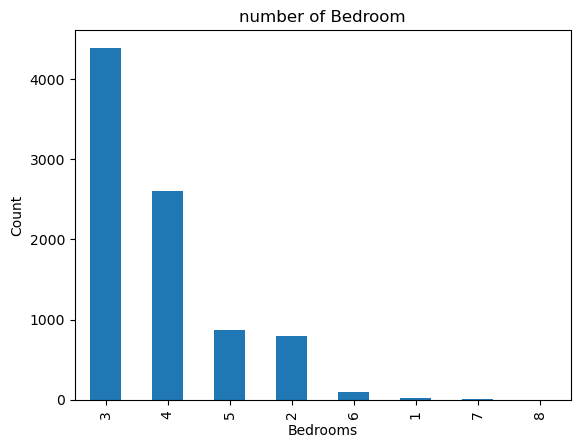

In [9]:
data_df['props.bedrooms'].value_counts().plot(kind='bar')
plt.title('number of Bedroom')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
sns.despine

Text(0.5, 1.0, 'Price vs Square Feet')

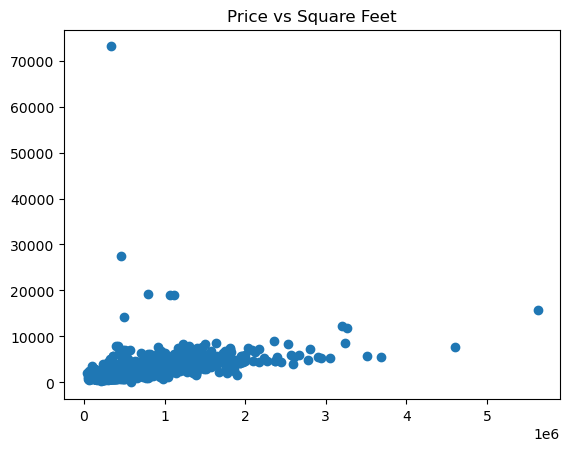

In [10]:
plt.scatter(data_df["props.zestimate"],data_df["props.livingArea"])
plt.title("Price vs Square Feet")

In [11]:
# Create dataframe that contains all variables except the zestimates
train_data = data_df.drop(['props.zestimate','props.longitude','props.latitude'], axis=1)
train_data

,props.city,props.zipcode,props.propertyType,props.bedrooms,props.bathrooms,props.livingArea,props.lotAreaValue
0,Wake Forest,27587,SINGLE_FAMILY,3,3,2245.0,0.920000
1,Wake Forest,27587,SINGLE_FAMILY,3,3,1815.0,0.350000
2,Wake Forest,27587,SINGLE_FAMILY,3,3,2350.0,0.429982
3,Wake Forest,27587,SINGLE_FAMILY,3,2,1332.0,0.260000
4,Wake Forest,27587,SINGLE_FAMILY,4,3,2600.0,0.920000
...,...,...,...,...,...,...,...
8842,Durham,27704,SINGLE_FAMILY,3,2,1310.0,0.480000
8843,Durham,27704,SINGLE_FAMILY,3,3,1263.0,8276.400000
8844,Durham,27704,SINGLE_FAMILY,3,3,1772.0,8276.400000
8845,Durham,27704,SINGLE_FAMILY,3,2,1408.0,0.326000


In [13]:
# categorical columns
categorical_cols = ['props.city','props.propertyType']

train_data= pd.get_dummies(train_data, columns = categorical_cols)
train_data

,props.zipcode,props.bedrooms,props.bathrooms,props.livingArea,props.lotAreaValue,props.city_Apex,props.city_Cary,props.city_Chapel Hill,props.city_Creedmoor,props.city_Durh,...,props.city_Raleigh,props.city_Rolesville,props.city_Wake Forest,props.propertyType_APARTMENT,props.propertyType_CONDO,props.propertyType_LOT,props.propertyType_MANUFACTURED,props.propertyType_MULT_FAMILY,props.propertyType_SINGLE_FAMILY,props.propertyType_TOWNHOUSE
0,27587,3,3,2245.0,0.920000,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,27587,3,3,1815.0,0.350000,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,27587,3,3,2350.0,0.429982,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,27587,3,2,1332.0,0.260000,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,27587,4,3,2600.0,0.920000,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,27704,3,2,1310.0,0.480000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8843,27704,3,3,1263.0,8276.400000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8844,27704,3,3,1772.0,8276.400000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8845,27704,3,2,1408.0,0.326000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [14]:
# set up linear regression on data
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

In [15]:
# Train-Test-Split data
from sklearn.model_selection import train_test_split

labels = data_df['props.zestimate']
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, test_size = 0.20, random_state = 42)

In [16]:
reg.fit(x_train,y_train)

LinearRegression()

In [17]:
reg.score(x_test,y_test)

0.4923623166124812

In [18]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'squared_error')

In [19]:
clf.fit(x_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=400)

In [22]:
clf.score(x_test,y_test)

0.7125122661822595

In [23]:
## Train the model with PMML wrapper
from sklearn2pmml.pipeline import PMMLPipeline

clf = PMMLPipeline(
    [
        (
            "classifier",
            ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'squared_error'),
        )
    ]
)

ModuleNotFoundError: No module named 'sklearn2pmml'

In [ ]:
clf.fit(x_train, y_train)

In [ ]:
clf.score(x_test,y_test)

In [ ]:
## Save model to PMML
from sklearn2pmml import sklearn2pmml

sklearn2pmml(clf, "boosting_model.pmml", with_repr=True)

In [ ]:
try:
	subprocess.check_call(["java", "-cp", _classpath(), "org.jpmml.sklearn.Main"])
except CalledProcessError:
	raise RuntimeError("The JPMML-SkLearn conversion application has failed.")